## Customer Segmentation with RFM Analysis

This notebook performs Exploratory Data Analysis (EDA) for a UK-based E-Commerce dataset to prepare for customer segmentation using RFM (Recency, Frequency, Monetary) features.

### Objective:
To identify meaningful customer groups to support targeted marketing and personalization strategies using unsupervised learning techniques.

### Dataset Summary:
- Transactions from a UK-based online retailer (December 2010 – December 2011)
- Includes details such as Invoice No., StockCode, Quantity, InvoiceDate, UnitPrice, and CustomerID


In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
df = pd.read_csv('../data/raw/data.csv', encoding='ISO-8859-1')

#basis overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
#2. Data Cleaning

# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace = True)

# Remove negative and zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceData to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [6]:
# RFM Feature Engineering 

# Set snapshot date
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x:(snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': lambda x: np.sum(x)
}).rename(columns ={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

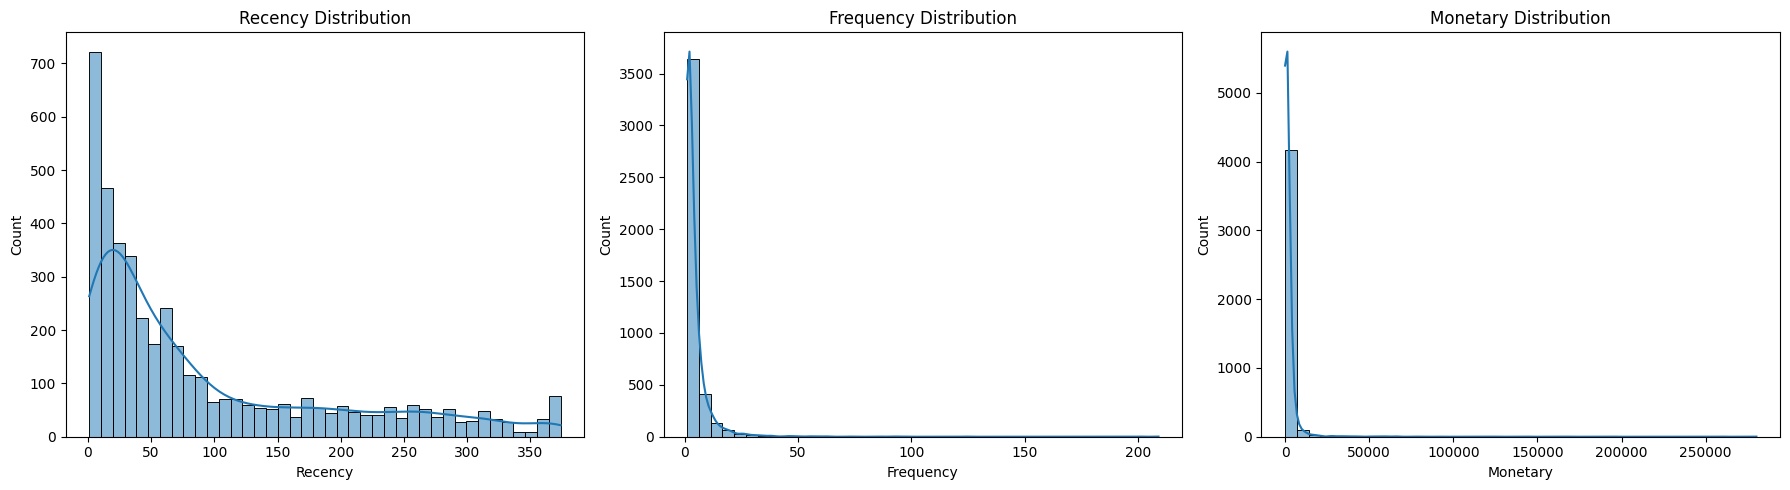

In [7]:
# Univariate Analysis

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'] , bins=40, kde = True, ax= axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=40, kde= True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins= 40, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()

- Recence is right-skewed -- most customers haven't purchased recently.
- Frequency and Monetary show extreme outliers -- some customers buy a lot or spend heavily.

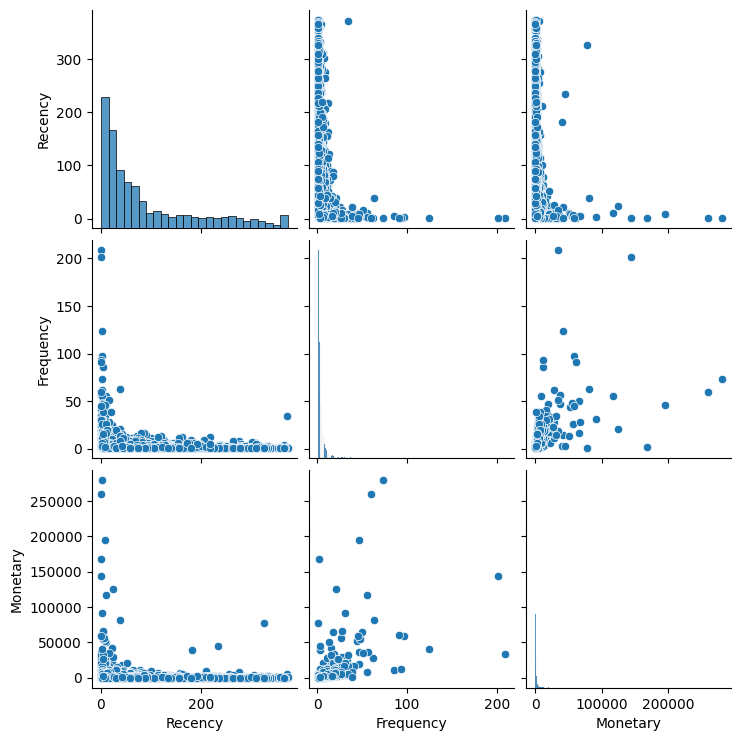

In [12]:
# Bivariate & Multivariate Analysis
sns.pairplot(rfm[['Recency', 'Frequency','Monetary']])


<Axes: >

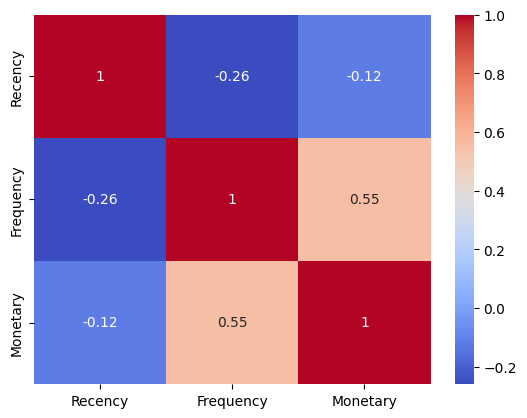

In [13]:
sns.heatmap(rfm[['Recency', 'Frequency','Monetary']].corr(), annot= True, cmap='coolwarm')

- Negative correlation between Recency and Frequency -- recent buyers tend to purchase more.
- Strong positive correlation between Frequency and Monetary.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

## EDA Summary

- Cleaned dataset contains ~4,000 valid customers.
- RFM features are computed to capture customer behavior.
- Monetary and Frequency show extreme outliers — addressed through scaling.
- Correlation analysis reveals clear patterns among RFM features.
- Both StandardScaler and RobustScaler applied for modeling comparison.

## Next Step:
Proceed to modeling notebook (`02_modeling.ipynb`) to perform clustering (KMeans, DBSCAN), evaluate segments, and extract business insights.


In [16]:
rfm.to_csv('../data/processed/processed_data1.csv')